# DeepEyeNet-Image Captioning with key word reinforced

## Keyword Model Part

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import json
import os
import re
import pickle
from tqdm import tqdm
from collections import defaultdict
import nltk
import h5py
import warnings
warnings.filterwarnings('ignore')
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing import sequence, image
from keras.models import Sequential, Model, Input
from keras.layers import LSTM, Embedding, Concatenate, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Add, Lambda, Dot
from keras.layers.wrappers import Bidirectional
from keras.optimizers import Adam, RMSprop
import keras.backend as K
from keras.models import load_model
import h5py

from model.model import CaptionModel
from model.model_k import AttentionModel, EncoderModel, MeanModel
from utils import *


# Load Data

In [4]:
# train_imgs, val_imgs, test_imgs
train_imgs = load_pickle('./data/data_path/train_imgs.pkl')
val_imgs = load_pickle('./data/data_path/val_imgs.pkl')
test_imgs = load_pickle('./data/data_path/test_imgs.pkl')

# imgs features
train_imgs_features_vgg16 = load_pickle('./data/img_features/train_imgs_features_vgg_sub.pkl')
val_imgs_features_vgg16 = load_pickle('./data/img_features/val_imgs_features_vgg_sub.pkl')
test_imgs_features_vgg16 = load_pickle('./data/img_features/test_imgs_features_vgg_sub.pkl')

train_imgs_features_vgg19 = load_pickle('./data/img_features/train_imgs_features_vgg19_sub.pkl')
val_imgs_features_vgg19 = load_pickle('./data/img_features/val_imgs_features_vgg19_sub.pkl')
test_imgs_features_vgg19 = load_pickle('./data/img_features/test_imgs_features_vgg19_sub.pkl')

train_imgs_features_inceptionV3 = load_pickle('./data/img_features/train_imgs_features_inceptionV3_sub.pkl')
val_imgs_features_inceptionV3 = load_pickle('./data/img_features/val_imgs_features_inceptionV3_sub.pkl')
test_imgs_features_inceptionV3 = load_pickle('./data/img_features/test_imgs_features_inceptionV3_sub.pkl')

# Important features
results = load_pickle('./data/data_path/results.pkl')

In [5]:
names = results["name"]
keywords = results["keywords"]
descriptions = results["descriptions"]
cap_toks = results["cap_toks"]
cap_ids = results["cap_ids"]
word2id = results["word2id"]
id2word = results["id2word"]
word2id_keys = results["word2id_keys"]
keywords_ids = results["keywords_ids"]

In [6]:
# Parameters
vocab_size = len(word2id)
max_len = max([len(x) for x in cap_toks.values()])
embedding_size = 300
new_vocab_size = len(word2id_keys)
key_max_len = max([len(x) for x in keywords_ids.values()])
steps_per_epoch = sum([len(cap_toks[img])-1 for img in train_imgs])

param = {}
param["key_max_len"] = key_max_len
param["keywords_ids"] = results['keywords_ids']
param["embedding_size"] = embedding_size
param["vocab_size"] = new_vocab_size
param["max_len"] = max_len
param["word2id"] = results["word2id"]
param["id2word"] = results["id2word"]

# Build the New Keyword Model

Here we would like to build some new keyword embedded model to test the performances.

In [6]:
# Load Glove vectors
embeddings_index = {}
with open('./word_embedding/glove.6B.300d.txt', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
# Get 200-dim dense vector
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in word2id.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
save_pickle(embedding_matrix, './data/data_path/embeddings.pkl')

## Let's Create the model

In [7]:
# 1. First approach: image-driven attention model for keyword embedding
model_obj_a = AttentionModel(param, 4096)
final_model_a = model_obj_a.forward()

# 2. RNN-Encoder for keyword embedding
model_obj_r = EncoderModel(param, 4096)
final_model_r = model_obj_r.forward()

# 3. RNN-Encoder for keyword embedding
model_obj_k = MeanModel(param, 4096)
final_model_k = model_obj_k.forward()

## Training

In [8]:
def train(model_obj, model, model_path, train=True):
    if os.path.exists(model_path):
        model = load_model(model_path)
        if not train:
            return model
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    model.fit_generator(model_obj.data_generator_k(train_imgs_features, train_imgs, cap_ids, batch_size = 64), 
                        steps_per_epoch=steps_per_epoch, epochs=1)
    model.save(model_path)
    
    return model

## 1. Attention Model

In [13]:
final_model_a = train(model_obj_a, final_model_a,'./checkpoints/model_vgg_new_keywords_attention.h5')

Epoch 1/1
16869/16869 [==============================] - 2441s 145ms/step - loss: 1.7947 - acc: 0.5819


In [8]:
final_model_a = train(model_obj_a, final_model_a,'./checkpoints/model_vgg_new_keywords_attention.h5')

Epoch 1/1
16869/16869 [==============================] - 2409s 143ms/step - loss: 0.5904 - acc: 0.8459


In [11]:
final_model_a = train(model_obj_a, final_model_a,'./checkpoints/model_vgg_new_keywords_attention.h5')

Epoch 1/1
16869/16869 [==============================] - 2518s 149ms/step - loss: 0.3439 - acc: 0.9085


In [23]:
final_model_a.save('./checkpoints/model_vgg_new_keywords_attention.h5')

In [8]:
final_model_a = load_model('./checkpoints/model_vgg_new_keywords_attention.h5')

## 2. Encoder Model

In [16]:
final_model_r = train(model_obj_r, final_model_r,'./checkpoints/model_vgg_new_keywords_encoder.h5')

Epoch 1/1
16869/16869 [==============================] - 2698s 160ms/step - loss: 0.9606 - acc: 0.7776


In [10]:
final_model_r = train(model_obj_r, final_model_r,'./checkpoints/model_vgg_new_keywords_encoder.h5')

Epoch 1/1
16869/16869 [==============================] - 2691s 160ms/step - loss: 0.2899 - acc: 0.9210


In [10]:
final_model_r = train(model_obj_r, final_model_r,'./checkpoints/model_vgg_new_keywords_encoder.h5')

Epoch 1/1
16869/16869 [==============================] - 2685s 159ms/step - loss: 0.2245 - acc: 0.9375


In [13]:
final_model_r.save('./checkpoints/model_vgg_new_keywords_encoder.h5')

In [15]:
final_model_r = load_model('./checkpoints/model_vgg_new_keywords_encoder.h5')

## 3. Mean Model

In [14]:
final_model_k = train(model_obj_k, final_model_k,'./checkpoints/model_vgg_new_keywords_mean.h5')

Epoch 1/1
16869/16869 [==============================] - 2420s 143ms/step - loss: 0.7531 - acc: 0.8055


In [14]:
final_model_k = train(model_obj_k, final_model_k,'./checkpoints/model_vgg_new_keywords_mean.h5')

Epoch 1/1
16869/16869 [==============================] - 2425s 144ms/step - loss: 0.4872 - acc: 0.8756


In [15]:
final_model_k.save('./checkpoints/model_vgg_new_keywords_mean.h5')

In [16]:
final_model_k = load_model('./checkpoints/model_vgg_new_keywords_mean.h5')

# Prediction

In [9]:
# For single img calculating bleu scores
def get_bleu_score(idd, imgs, imgs_features):
    
    model_objs = [model_obj_a, model_obj_r, model_obj_k]
    models = [final_model_a, final_model_r, final_model_k]
    names = ['attention', 'encoder', 'mean']
    predicted = []
    
    for obj, model in zip(model_objs, models):
        predicted.append(obj.predict_captions_k(imgs[idd], imgs_features, model))
    ground_truth = descriptions[imgs[idd]]
    ground_truth_tok = [model_obj_a.text_prepare(ground_truth)]
    
    print('Ground Truth Caption: {}'.format(ground_truth))
    for pred, name, obj in zip(predicted, names, model_objs):
        print('\nPredicted Caption ({}): {}'.format(name,pred))
        predicted_tok = obj.text_prepare(pred)
        print('Bleu Score ({}): {}'.format(name, sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))))

In [10]:
# For imgs calculating bleu scores
def evaluate_bleu(imgs, imgs_feats, model, obj, key_flag):
    
    avgscore = 0

    for i in tqdm(range(len(imgs))):
        if key_flag:
            predicted = obj.predict_captions_k(imgs[i], imgs_feats, model)
        else:
            predicted = obj.predict_captions(imgs[i], imgs_feats, model)
        ground_truth = results['descriptions'][imgs[i]]
        predicted_tok = obj.text_prepare(predicted)
        ground_truth_tok = [obj.text_prepare(ground_truth)]
        
        avgscore += sentence_bleu(ground_truth_tok, predicted_tok, weights=(1, 0, 0, 0))
    
    avgscore /= len(imgs)
    return avgscore

In [11]:
# Predict captions and place them in json files
def predict_captions(imgs, imgs_feats, model, obj, key_flag):
    gts, res = {}, {}
    for i,img in tqdm(enumerate(imgs)):
        if key_flag:
            predicted = text_prepare(obj.predict_captions_k(img, imgs_feats, model))
        else:
            predicted = text_prepare(obj.predict_captions(img, imgs_feats, model))
        ground_truth = text_prepare(results['descriptions'][img])
        
        # ground truth
        if img not in gts:
            gts[img] = [ground_truth]
        else:
            gts[img] = [gts[img], ground_truth]
        if img not in res:
            res[img] = [predicted]
        else:
            res[img] = [res[img], predicted]
        
    return gts, res

## BLEU Score

Ground Truth Caption: left eye fundus of a 55-year-old lady shows rpe atrophy at macular center and multiple drusen.

Predicted Caption (attention): left eye fundus of a 55 year old lady shows rpe atrophy at macular center and multiple drusen.
Bleu Score (attention): 1.0

Predicted Caption (encoder): right eye fundus of a 55 year old lady shows rpe atrophy at macular center and multiple drusen.
Bleu Score (encoder): 0.95

Predicted Caption (mean): left eye fundus of a 55 year old lady shows rpe atrophy at macular center and multiple drusen.
Bleu Score (mean): 1.0


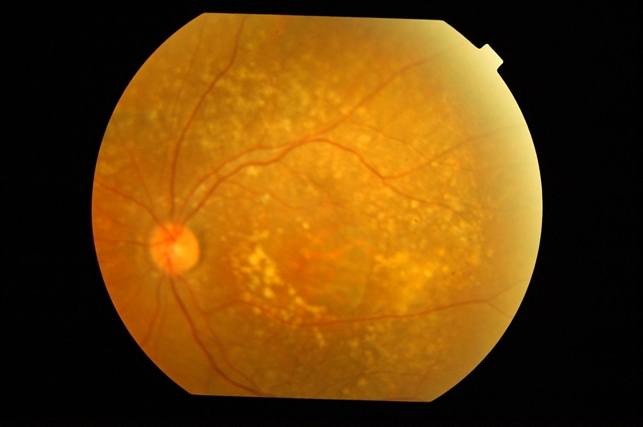

In [16]:
idd = 112
get_bleu_score(idd, train_imgs, train_imgs_features)
Image.open(train_imgs[idd]+'.jpg')

In [16]:
test_bleu_a = evaluate_bleu(test_imgs, test_imgs_features, final_model_a, model_obj_a, 1)
test_bleu_r = evaluate_bleu(test_imgs, test_imgs_features, final_model_r, model_obj_r, 1)
test_bleu_k = evaluate_bleu(test_imgs, test_imgs_features, final_model_k, model_obj_k, 1)

100%|██████████| 196/196 [01:27<00:00,  3.22it/s]


In [18]:
print('Test Bleu Score ({}): {}'.format('attention',test_bleu_a))
print('Test Bleu Score ({}): {}'.format('encoder',test_bleu_r))
print('Test Bleu Score ({}): {}'.format('mean',test_bleu_k))

Test Bleu Score (attention): 0.7280482098387687
Test Bleu Score (encoder): 0.6676536127692434
Test Bleu Score (mean): 0.6859904912714635


## CIDEr, Rouge

In [20]:
test_gts_a, test_res_a = predict_captions(test_imgs, test_imgs_features, final_model_a, model_obj_a, 1)
test_gts_r, test_res_r = predict_captions(test_imgs, test_imgs_features, final_model_r, model_obj_r, 1)
test_gts_k, test_res_k = predict_captions(test_imgs, test_imgs_features, final_model_k, model_obj_k, 1)

196it [01:30,  4.28it/s]
196it [01:25,  3.56it/s]
196it [01:27,  3.20it/s]


In [21]:
from eval_tools import Cider, Rouge

def calc_scores(scorer, name, model, gts_k, res_k):
    print('-----------------------------')
    print(name+':')
    (score, scores) = scorer.compute_score(gts_k, res_k)
    print('train %s score (%s) = %.4f' % (name,model,score))
    return score

In [22]:
scores_ca = calc_scores(Cider(), 'cider', 'attention', test_gts_a, test_res_a)
scores_cr = calc_scores(Cider(), 'cider', 'encoder', test_gts_r, test_res_r)
scores_ck = calc_scores(Cider(), 'cider', 'mean', test_gts_k, test_res_k)
scores_ra = calc_scores(Rouge(), 'rouge', 'attention', test_gts_a, test_res_a)
scores_rr = calc_scores(Rouge(), 'rouge', 'encoder', test_gts_r, test_res_r)
scores_rk = calc_scores(Rouge(), 'rouge', 'mean', test_gts_k, test_res_k)

-----------------------------
cider:
train cider score (attention) = 3.9594
-----------------------------
cider:
train cider score (encoder) = 3.2441
-----------------------------
cider:
train cider score (mean) = 3.4051
-----------------------------
rouge:
train rouge score (attention) = 0.6950
-----------------------------
rouge:
train rouge score (encoder) = 0.6382
-----------------------------
rouge:
train rouge score (mean) = 0.6508
